In [1]:
!pip install tensorflow_datasets imageio scikit-image

In [2]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds
tf.__version__

'2.0.1'

## Загрузка и подготовка датасета LFW

In [3]:
(train_ds, test_ds), ds_info = tfds.load(
    'lfw',
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'],
)

```python
FeaturesDict({  
    'image': Image(shape=(250, 250, 3), dtype=tf.uint8),  
    'label': Text(shape=(), dtype=tf.string),
})
```

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

In [5]:
ds_info.splits['train'].num_examples

13233

In [6]:
train_ds

<PrefetchDataset shapes: ((), (250, 250, 3)), types: (tf.string, tf.uint8)>

## Подготовка пайплайна данных

In [7]:
def normalize_example(label, image):
    return label, tf.cast(image, tf.float32) / 255.

In [8]:
NUM_EPOCHS = 10
BATCH_SIZE = 64

train_ds = train_ds.shuffle(buffer_size=int(ds_info.splits['train'].num_examples*0.9)).map(normalize_example, num_parallel_calls=16).batch(BATCH_SIZE, drop_remainder=True).repeat(NUM_EPOCHS).prefetch(16)
test_ds = test_ds.shuffle(buffer_size=int(ds_info.splits['train'].num_examples*0.1)).map(normalize_example, num_parallel_calls=16).batch(BATCH_SIZE, drop_remainder=True)

In [9]:
for rec in train_ds:
    print(rec)
    break

(<tf.Tensor: id=356, shape=(64,), dtype=string, numpy=
array([b'Tom_Cruise', b'Ahmet_Necdet_Sezer', b'Vivica_Fox',
       b'Atal_Bihari_Vajpayee', b'Charlene_Barshefsky', b'Aishwarya_Rai',
       b'Ricardo_Lagos', b'Kim_Jong-Il', b'Jennie_Finch',
       b'Catherine_Deneuve', b'Mary_Carey', b'Tony_LaRussa',
       b'Oprah_Winfrey', b'Paul_Bremer', b'Patrick_Stewart',
       b'Diana_Krall', b'Antonio_Palocci', b'Gerhard_Schroeder',
       b'Barrett_Jackman', b'George_W_Bush', b'Heizo_Takenaka',
       b'Hugo_Chavez', b'Bill_Gates', b'Gerhard_Schroeder',
       b'Andre_Smith', b'Laura_Bush', b'Sinead_OConnor', b'Rick_Wagoner',
       b'Sheila_Copps', b'Rudolph_Holton', b'Steve_Case',
       b'Henry_Castellanos', b'James_Parker', b'Gerhard_Schroeder',
       b'Bill_Frist', b'Tatiana_Gratcheva', b'Vanessa_Incontrada',
       b'Barry_Williams', b'Sammy_Knight', b'Colin_Powell',
       b'Joseph_Salgado', b'Arnoldo_Aleman', b'Martin_Verkerk',
       b'Gerhard_Schroeder', b'David_Obey', b'Luis_

## Визуализация датасета LFW

In [10]:
sample = next(iter(train_ds))

In [11]:
sample_x = sample[1].numpy()[:25]
sample_x

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.00784314, 0.        ],
         [0.        , 0.00784314, 0.        ],
         [0.        , 0.00784314, 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.00392157, 0.        ],
         [0.        , 0.00392157, 0.        ],
         [0.        , 0.00392157, 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.01176471, 0.        , 0.01568628],
         [0.01176471, 0.        , 0.01568628],
         [0.01176471, 0.        , 0.00784314]],

        ...,

        [[0.80784315, 0.79607844, 0.87058824],
         [0.7921569 , 0.78039217, 0.85490197]

In [12]:
sample_x.shape

(25, 250, 250, 3)

In [13]:
sample_y = sample[0].numpy()[:25]
sample_y

array([b'Michael_DeMinico', b'Jake_Plummer', b'Mario_Puzo',
       b'Richard_Gephardt', b'Laura_Bush', b'Richard_Branson',
       b'Sean_Patrick_OMalley', b'Tiffany_Limos', b'Colin_Powell',
       b'Antje_Buschschulte', b'Roy_Moore', b'John_Brady',
       b'Geraldine_Chaplin', b'Guillermo_Coria', b'Ai_Sugiyama',
       b'Marisa_Tomei', b'Dave_Barr', b'JP_Suarez', b'Walter_Mondale',
       b'Rubens_Barrichello', b'Stella_McCartney', b'Woodrow_Stanley',
       b'Ekke_Hard_Forberg', b'John_Kerry', b'Thomas_Malchow'],
      dtype=object)

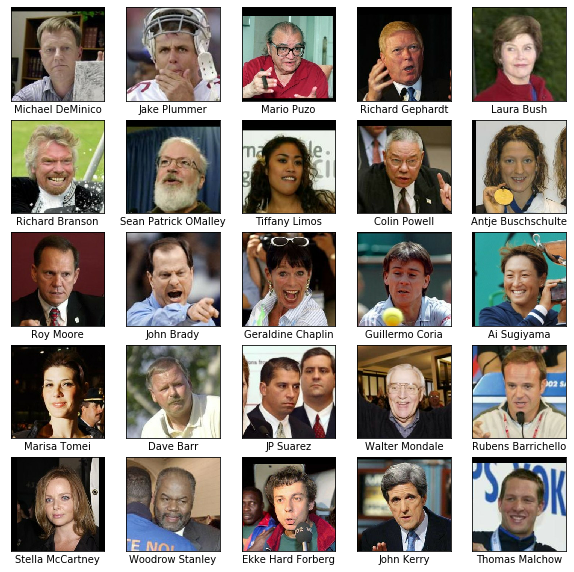

In [14]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_x[i].reshape(250,250,3))
    plt.xlabel(sample_y[i].decode().replace("_", " "))
plt.show()

## Создание модели CNN

In [15]:
try:
    del model
    tf.keras.backend.clear_session()
except:
    pass

In [16]:
# EMB_SIZE = 128

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
#     tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
#     tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
#     tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(EMB_SIZE, activation=None),
# ])

In [17]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (4, 4), padding='same', activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Conv2D(64, (4, 4), padding='same', activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

## Contrastive Loss

In [18]:
MARGIN = 10.0

def contrastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

## Подготовка к обучению

In [19]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [20]:
%%time

for iteration, (labels, images) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contrastive_loss(embs, labels)
        
    # Backward
#     grads = tape.gradient(loss_value, model.variables)
#     optimizer.apply_gradients(zip(grads, model.variables))
    
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients([(grad, var) for (grad, var) in zip(grads, model.trainable_variables) if grad is not None])

    if iteration % 50 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 99.79376220703125
[50] Loss: 0.0
[100] Loss: 0.6752564311027527
[150] Loss: 3.1606478691101074
[200] Loss: 2.003028631210327
[250] Loss: 7.149580955505371
[300] Loss: 5.261301517486572
[350] Loss: 6.016185283660889
[400] Loss: 7.009763240814209
[450] Loss: 25.942663192749023
[500] Loss: 3.465909957885742
[550] Loss: 10.848094940185547
[600] Loss: 2.977576494216919
[650] Loss: 10.276082992553711
[700] Loss: 0.0
[750] Loss: 14.996241569519043
[800] Loss: 15.903852462768555
[850] Loss: 2.7137842178344727
[900] Loss: 13.167173385620117
[950] Loss: 5.399134635925293
[1000] Loss: 6.080007076263428
[1050] Loss: 2.901398181915283
[1100] Loss: 8.57080078125
[1150] Loss: 12.865842819213867
[1200] Loss: 4.866238594055176
[1250] Loss: 10.110115051269531
[1300] Loss: 5.480673313140869
[1350] Loss: 0.0
[1400] Loss: 15.4855318069458
[1450] Loss: 4.965978622436523
[1500] Loss: 3.417393922805786
[1550] Loss: 7.2588114738464355
[1600] Loss: 2.850306987762451
[1650] Loss: 8.029802322387695
[170

## Тестирование на новых данных

In [21]:
test_sample = next(iter(test_ds))

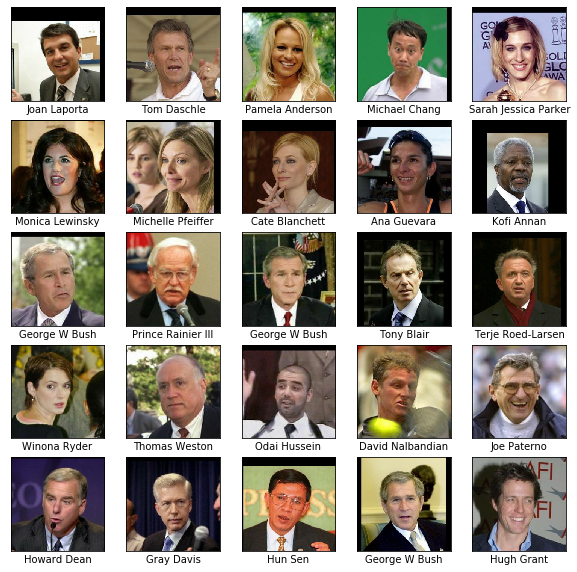

In [22]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_sample[1][i].numpy().reshape(250,250,3))
    plt.xlabel(test_sample[0][i].numpy().decode().replace("_", " "))
plt.show()

In [23]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (250, 250, 3), mode='reflect', anti_aliasing=True)
    img = np.reshape(img, (250, 250, 3))
    return img

In [24]:
def predict_embed_on_imagefile(model, imagefilepath):
    img = load_and_prepare_image(imagefilepath)
#     return model.predict(img.reshape([1,250,250,3]))
    return model(img.reshape([1,250,250,3]))

In [25]:
def predict_embed_on_imagearray(model, imagearray):
#     return model.predict(imagearray.reshape([1,250,250,3]))
    return model(imagearray.reshape([1,250,250,3]))

In [26]:
myface_1_img = load_and_prepare_image("myface_1.jpg")
myface_1_predict = predict_embed_on_imagearray(model, myface_1_img)

myface_2_img = load_and_prepare_image("myface_2.jpg")
myface_2_predict = predict_embed_on_imagearray(model, myface_2_img)

myface_3_img = load_and_prepare_image("myface_3.jpg")
myface_3_predict = predict_embed_on_imagearray(model, myface_3_img)

In [27]:
test_sample_face0_predict = predict_embed_on_imagearray(model, test_sample[1][0].numpy())
test_sample_face0_name = test_sample[0][0].numpy().decode().replace("_", " ")

test_sample_face1_predict = predict_embed_on_imagearray(model, test_sample[1][1].numpy())
test_sample_face1_name = test_sample[0][1].numpy().decode().replace("_", " ")

test_sample_face2_predict = predict_embed_on_imagearray(model, test_sample[1][2].numpy())
test_sample_face2_name = test_sample[0][2].numpy().decode().replace("_", " ")

In [28]:
test_names = ["Nikolay Pomazan #1", "Nikolay Pomazan #2", "Nikolay Pomazan #3", test_sample_face0_name, test_sample_face1_name, test_sample_face2_name]
test_images = [myface_1_img, myface_2_img, myface_3_img, test_sample[1][0].numpy(), test_sample[1][1].numpy(), test_sample[1][2].numpy()]

tmp_list = list(zip(test_names, test_images))
random.shuffle(tmp_list)
test_names, test_images = zip(*tmp_list)

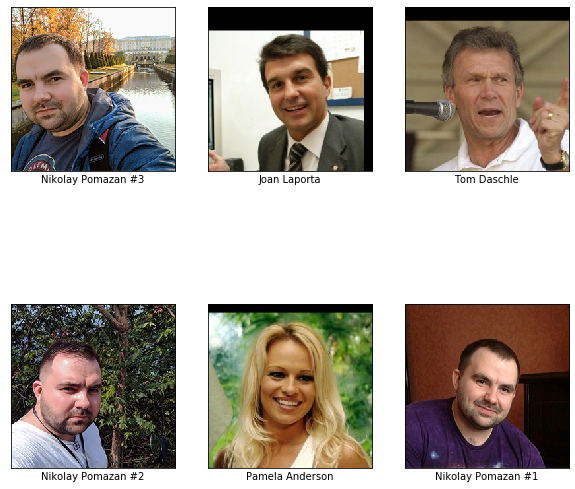

In [29]:
plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i].reshape(250,250,3))
    plt.xlabel(test_names[i])
plt.show()

In [30]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

#### Сравнение своих рож между собой

In [31]:
print('Nikolay Pomazan #1 <-> Nikolay Pomazan #2: ', diff(myface_1_predict, myface_2_predict))

Nikolay Pomazan #1 <-> Nikolay Pomazan #2:  7.2825816496211315


In [32]:
print('Nikolay Pomazan #1 <-> Nikolay Pomazan #3: ', diff(myface_1_predict, myface_3_predict))

Nikolay Pomazan #1 <-> Nikolay Pomazan #3:  35.340392745058736


In [33]:
print('Nikolay Pomazan #2 <-> Nikolay Pomazan #3: ', diff(myface_2_predict, myface_3_predict))

Nikolay Pomazan #2 <-> Nikolay Pomazan #3:  28.05787236516975


#### Сравнение своих рож с кандидатом №1

In [34]:
print('Nikolay Pomazan #1 <-> %s: ' % test_sample_face0_name, diff(myface_1_predict, test_sample_face0_predict))

Nikolay Pomazan #1 <-> Joan Laporta:  41.09778972539156


In [35]:
print('Nikolay Pomazan #2 <-> %s: ' % test_sample_face0_name, diff(myface_2_predict, test_sample_face0_predict))

Nikolay Pomazan #2 <-> Joan Laporta:  33.81524004031873


In [36]:
print('Nikolay Pomazan #3 <-> %s: ' % test_sample_face0_name, diff(myface_3_predict, test_sample_face0_predict))

Nikolay Pomazan #3 <-> Joan Laporta:  5.757526281895616


#### Сравнение своих рож с кандидатом №2

In [37]:
print('Nikolay Pomazan #1 <-> %s: ' % test_sample_face1_name, diff(myface_1_predict, test_sample_face1_predict))

Nikolay Pomazan #1 <-> Tom Daschle:  29.149906363753985


In [38]:
print('Nikolay Pomazan #2 <-> %s: ' % test_sample_face1_name, diff(myface_2_predict, test_sample_face1_predict))

Nikolay Pomazan #2 <-> Tom Daschle:  21.86735427209538


In [39]:
print('Nikolay Pomazan #3 <-> %s: ' % test_sample_face1_name, diff(myface_3_predict, test_sample_face1_predict))

Nikolay Pomazan #3 <-> Tom Daschle:  6.190595988976382


#### Сравнение своих рож с кандидатом №3

In [40]:
print('Nikolay Pomazan #1 <-> %s: ' % test_sample_face2_name, diff(myface_1_predict, test_sample_face2_predict))

Nikolay Pomazan #1 <-> Pamela Anderson:  40.807097890946004


In [41]:
print('Nikolay Pomazan #2 <-> %s: ' % test_sample_face2_name, diff(myface_2_predict, test_sample_face2_predict))

Nikolay Pomazan #2 <-> Pamela Anderson:  33.52455628376664


In [42]:
print('Nikolay Pomazan #3 <-> %s: ' % test_sample_face2_name, diff(myface_3_predict, test_sample_face2_predict))

Nikolay Pomazan #3 <-> Pamela Anderson:  5.466743842409794


#### Сравнение кандидатов между собой

In [43]:
print('%s <-> %s: ' % (test_sample_face0_name, test_sample_face1_name), diff(test_sample_face0_predict, test_sample_face1_predict))

Joan Laporta <-> Tom Daschle:  11.94788488080631


In [44]:
print('%s <-> %s: ' % (test_sample_face0_name, test_sample_face2_name), diff(test_sample_face0_predict, test_sample_face2_predict))

Joan Laporta <-> Pamela Anderson:  0.2912869436753017


In [45]:
print('%s <-> %s: ' % (test_sample_face1_name, test_sample_face2_name), diff(test_sample_face1_predict, test_sample_face2_predict))

Tom Daschle <-> Pamela Anderson:  11.657207541727068


## По результатам в тесте получилась какая-то фигня, на мой взгляд. Но весь пайплайн построен, вероятно надо играться с архитектурой модели.